# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 
# Fire up GraphLab Create
 
Make sure you have the latest version of GraphLab Create. Upgrade by

```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [1]:
from __future__ import division
import pandas as pd
#import graphlab

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [2]:
#products = graphlab.SFrame('amazon_baby_subset.gl/')
products = pd.read_csv("amazon_baby_subset.csv")
print(products.head())
products = products.fillna({'review':''})

                                                name  \
0  Stop Pacifier Sucking without tears with Thumb...   
1    Nature's Lullabies Second Year Sticker Calendar   
2    Nature's Lullabies Second Year Sticker Calendar   
3                        Lamaze Peekaboo, I Love You   
4  SoftPlay Peek-A-Boo Where's Elmo A Children's ...   

                                              review  rating  sentiment  
0  All of my kids have cried non-stop when I trie...       5          1  
1  We wanted to get something to keep track of ou...       5          1  
2  My daughter had her 1st baby over a year ago. ...       5          1  
3  One of baby's first and favorite books, and it...       4          1  
4  Very cute interactive book! My son loves this ...       5          1  


Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to Module 3 assignment for more details.

In [3]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]


def remove_punctuation(text):
    import string
    return text.translate(string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)
# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).

In [4]:
products

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried non-stop when I trie...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago. ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"One of baby's first and favorite books, and it...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book! My son loves this ...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1,"Beautiful book, I love it to record cherished ...",0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1,"Try this out for a spring project !Easy ,fun a...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1,very nice Divine Mercy Pendant of Jesus now on...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1,We bought the pins as my 6 year old Autistic s...,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1,It has been many years since we needed diaper ...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [5]:
import numpy as np
df = pd.DataFrame(np.random.randn(len(products), 2))
mask = np.random.rand(len(df)) < 0.8

train_data, validation_data = products[mask], products[ ~mask]
#train_data, validation_data = train_test_split(products, test_size=0.2)
#train_data, validation_data = products[.random_split(.8, seed=2)]

print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 42387 data points
Validation set : 10685 data points


## Convert SFrame to NumPy array

Just like in the second assignment of the previous module, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [6]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.as_matrix()
    label_sarray = data_sframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array[:,None])

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [7]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Are you running this notebook on an Amazon EC2 t2.micro instance?** (If you are using your own machine, please skip this section)

It has been reported that t2.micro instances do not provide sufficient power to complete the conversion in acceptable amount of time. For interest of time, please refrain from running `get_numpy_data` function. Instead, download the [binary file](https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/numpy-arrays/module-4-assignment-numpy-arrays.npz) containing the four NumPy arrays you'll need for the assignment. To load the arrays, run the following commands:
```
arrays = np.load('module-4-assignment-numpy-arrays.npz')
feature_matrix_train, sentiment_train = arrays['feature_matrix_train'], arrays['sentiment_train']
feature_matrix_valid, sentiment_valid = arrays['feature_matrix_valid'], arrays['sentiment_valid']
```

## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [8]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    ## YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients )
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    ## YOUR CODE HERE
    predictions = 1 / (1 + np.exp(-score))
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [9]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(feature.T, errors)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative = derivative - 2* l2_penalty * feature
    derivative = derivative[:, None]  
    return derivative

** Quiz Question:** In the code above, was the intercept term regularized?

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [10]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

** Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [11]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative =  feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept) 
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size * np.sum( derivative[j] )
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp) )
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [12]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros([194,1]),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29241.03771396
iteration   1: log likelihood of observed labels = -29106.52638348
iteration   2: log likelihood of observed labels = -28976.44724693
iteration   3: log likelihood of observed labels = -28850.45688215
iteration   4: log likelihood of observed labels = -28728.28344396
iteration   5: log likelihood of observed labels = -28609.70431490
iteration   6: log likelihood of observed labels = -28494.53116868
iteration   7: log likelihood of observed labels = -28382.60001198
iteration   8: log likelihood of observed labels = -28273.76455006
iteration   9: log likelihood of observed labels = -28167.89176075
iteration  10: log likelihood of observed labels = -28064.85892944
iteration  11: log likelihood of observed labels = -27964.55164740
iteration  12: log likelihood of observed labels = -27866.86244297
iteration  13: log likelihood of observed labels = -27771.68982787
iteration  14: log likelihood of observed labels = -27678.9376

In [13]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros([194,1]),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29241.03522347
iteration   1: log likelihood of observed labels = -29106.53674021
iteration   2: log likelihood of observed labels = -28976.48143161
iteration   3: log likelihood of observed labels = -28850.52304706
iteration   4: log likelihood of observed labels = -28728.38791105
iteration   5: log likelihood of observed labels = -28609.85222190
iteration   6: log likelihood of observed labels = -28494.72688349
iteration   7: log likelihood of observed labels = -28382.84739591
iteration   8: log likelihood of observed labels = -28274.06712323
iteration   9: log likelihood of observed labels = -28168.25280468
iteration  10: log likelihood of observed labels = -28065.28154970
iteration  11: log likelihood of observed labels = -27965.03881116
iteration  12: log likelihood of observed labels = -27867.41700106
iteration  13: log likelihood of observed labels = -27772.31452743
iteration  14: log likelihood of observed labels = -27679.6351

In [14]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros([194,1]),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29241.03159349
iteration   1: log likelihood of observed labels = -29106.55264719
iteration   2: log likelihood of observed labels = -28976.53345309
iteration   3: log likelihood of observed labels = -28850.62348535
iteration   4: log likelihood of observed labels = -28728.54630410
iteration   5: log likelihood of observed labels = -28610.07632067
iteration   6: log likelihood of observed labels = -28495.02327860
iteration   7: log likelihood of observed labels = -28383.22191543
iteration   8: log likelihood of observed labels = -28274.52508237
iteration   9: log likelihood of observed labels = -28168.79916047
iteration  10: log likelihood of observed labels = -28065.92099531
iteration  11: log likelihood of observed labels = -27965.77583232
iteration  12: log likelihood of observed labels = -27868.25590908
iteration  13: log likelihood of observed labels = -27773.25947807
iteration  14: log likelihood of observed labels = -27680.6901

In [15]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros([194,1]),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29240.99323545
iteration   1: log likelihood of observed labels = -29106.84819824
iteration   2: log likelihood of observed labels = -28977.42849478
iteration   3: log likelihood of observed labels = -28852.31473898
iteration   4: log likelihood of observed labels = -28731.18625494
iteration   5: log likelihood of observed labels = -28613.78908796
iteration   6: log likelihood of observed labels = -28499.91474018
iteration   7: log likelihood of observed labels = -28389.38609544
iteration   8: log likelihood of observed labels = -28282.04812928
iteration   9: log likelihood of observed labels = -28177.76178554
iteration  10: log likelihood of observed labels = -28076.39993806
iteration  11: log likelihood of observed labels = -27977.84471926
iteration  12: log likelihood of observed labels = -27881.98574077
iteration  13: log likelihood of observed labels = -27788.71889400
iteration  14: log likelihood of observed labels = -27697.9455

In [16]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros([194,1]),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29243.15593633
iteration   1: log likelihood of observed labels = -29119.15949708
iteration   2: log likelihood of observed labels = -29005.92130751
iteration   3: log likelihood of observed labels = -28901.78993405
iteration   4: log likelihood of observed labels = -28805.67515987
iteration   5: log likelihood of observed labels = -28716.84437414
iteration   6: log likelihood of observed labels = -28634.79030489
iteration   7: log likelihood of observed labels = -28559.14635341
iteration   8: log likelihood of observed labels = -28489.63299208
iteration   9: log likelihood of observed labels = -28426.02417564
iteration  10: log likelihood of observed labels = -28368.12653678
iteration  11: log likelihood of observed labels = -28315.76668951
iteration  12: log likelihood of observed labels = -28268.78363437
iteration  13: log likelihood of observed labels = -28227.02434254
iteration  14: log likelihood of observed labels = -28190.3412

In [17]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros([194,1]),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -1040636.36918330
iteration   1: log likelihood of observed labels = -4024621.50510225
iteration   2: log likelihood of observed labels = -8966954.51849819
iteration   3: log likelihood of observed labels = -15865932.14446819
iteration   4: log likelihood of observed labels = -24721244.00052850
iteration   5: log likelihood of observed labels = -35532890.45540959
iteration   6: log likelihood of observed labels = -48300911.26089414
iteration   7: log likelihood of observed labels = -63025322.05955867
iteration   8: log likelihood of observed labels = -79706112.65738657
iteration   9: log likelihood of observed labels = -98343257.59351687
iteration  10: log likelihood of observed labels = -118936725.22173429
iteration  11: log likelihood of observed labels = -141486483.19721985
iteration  12: log likelihood of observed labels = -165992501.20361009
iteration  13: log likelihood of observed labels = -192454752.03046542
iteration  14: log 

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp


iteration  20: log likelihood of observed labels = -inf
iteration  30: log likelihood of observed labels = -inf
iteration  40: log likelihood of observed labels = -inf
iteration  50: log likelihood of observed labels = -inf
iteration  60: log likelihood of observed labels = -inf
iteration  70: log likelihood of observed labels = -inf
iteration  80: log likelihood of observed labels = -inf
iteration  90: log likelihood of observed labels = -inf
iteration 100: log likelihood of observed labels = -inf
iteration 200: log likelihood of observed labels = -inf
iteration 300: log likelihood of observed labels = -inf
iteration 400: log likelihood of observed labels = -inf
iteration 500: log likelihood of observed labels = -inf


## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [18]:
#table = graphlab.SFrame({'word': ['(intercept)'] + important_words})
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [19]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.069761,-0.068070,-0.065533,-0.027487,0.323794,6.157396
1,baby,0.098575,0.098938,0.099489,0.108580,0.312656,7.147751
2,one,0.017250,0.017976,0.019064,0.035300,0.269532,7.558589
3,great,0.761586,0.761801,0.762149,0.771310,1.193736,6.057403
4,love,1.058004,1.058345,1.058889,1.072061,1.592110,6.379766
5,use,0.060172,0.060926,0.062058,0.079276,0.333203,5.716548
6,would,-0.290551,-0.288950,-0.286567,-0.253348,-0.058296,5.063504
7,like,-0.022927,-0.022627,-0.022176,-0.015311,0.095764,4.893406
8,easy,1.002560,1.003489,1.004920,1.031982,1.719081,6.979271
9,little,0.528223,0.528589,0.529161,0.540799,0.968122,6.682059


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?


In [20]:
t_sorted = table.sort_values(by=['coefficients [L2=0]'], axis=0, ascending=True)
print(t_sorted)

             word  coefficients [L2=0]  coefficients [L2=4]  \
106  disappointed            -0.768491            -0.768263   
113         waste            -0.740017            -0.739982   
114        return            -0.725789            -0.725662   
97          money            -0.577001            -0.576826   
169      returned            -0.547013            -0.547081   
100       thought            -0.468898            -0.468953   
172         broke            -0.450481            -0.450362   
33           even            -0.427600            -0.427109   
78           work            -0.404220            -0.404103   
176          idea            -0.380328            -0.380195   
160     difficult            -0.368894            -0.368030   
134         cheap            -0.367095            -0.367085   
67            way            -0.356802            -0.356240   
19        product            -0.356463            -0.355961   
99          tried            -0.353655            -0.35

In [21]:
positive_words = ['loves', 'love', 'easy', 'great', 'perfect']
negative_words = ['waste', 'disappointed', 'return', 'money', 'returned']

Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.loc[table['word'].isin(positive_words)]
    table_negative_words = table.loc[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten())
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 'o', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

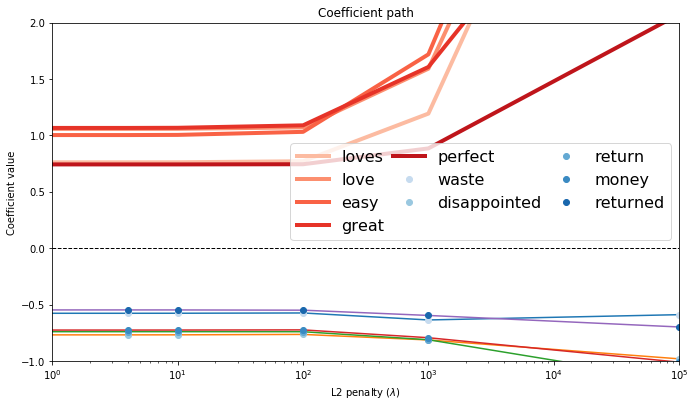

In [23]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [24]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [25]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [26]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.768372378324, validation_accuracy = 0.768366869443
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.768395970463, validation_accuracy = 0.76855404773
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.76898577394, validation_accuracy = 0.769770706598
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.765895203718, validation_accuracy = 0.765933551708
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.645150635808, validation_accuracy = 0.650163781001
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.508434189728, validation_accuracy = 0.512962096397
----------------------------------------------------------------------------

<function matplotlib.pyplot.tight_layout>

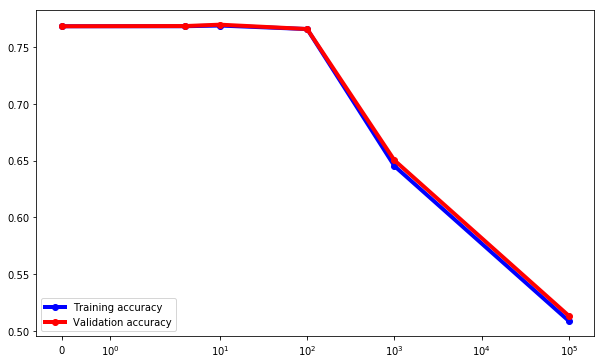

In [32]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
#plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?